# Weather forecasts on ERA5

This notebook shows how to initialize the Dinosaur dynamical core to perform a retrospective weather forecast initialized with ERA5.

It shows:

1. How to construct a Dinosaur initial state from reanalysis data, including data loading and unit conversion.
2. How to filter initial conditions using [digital filter initialization](https://journals.ametsoc.org/view/journals/mwre/120/6/1520-0493_1992_120_1019_iothmu_2_0_co_2.xml), which creates much better looking weather forecasts.
3. How to selectively calculated diagnostic quantity (e.g., vertical wind and geopotential) from the Dinosuar states.

Note: This notebook runs well on TPU v5e kernel in Google Colab. It also runs on an A100 GPU, but the compile time for some operations is quite slow (~6 minutes vs ~30 seconds) -- we are looking into this.

## Setup code

### Installation

In [1]:
! pip install -U -q dinosaur gcsfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.1/173.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 128.5 MB/s eta 0:00:00


### Imports

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray

from dinosaur import coordinate_systems
from dinosaur import filtering
from dinosaur import primitive_equations
from dinosaur import scales
from dinosaur import sigma_coordinates
from dinosaur import spherical_harmonic
from dinosaur import time_integration
from dinosaur import vertical_interpolation

units = scales.units

### Utilities

In [3]:

def attach_data_array_units(array):
  attrs = dict(array.attrs)
  units = attrs.pop('units', None)
  if units in {'(0 - 1)', '%', '~'}:
    units = None
  if units is not None:
    data = scales.units.parse_expression(units) * array.data
  else:
    data = scales.units.dimensionless * array.data
  return xarray.DataArray(data, array.coords, array.dims, attrs=attrs)


def attach_xarray_units(ds):
  return ds.map(attach_data_array_units)


def xarray_nondimensionalize(ds):
  return xarray.apply_ufunc(scales.DEFAULT_SCALE.nondimensionalize, ds)


def xarray_to_gcm_dict(ds, var_names=None):
  if var_names is None:
    var_names = ds.keys()
  result = {}
  for var_name in var_names:
    data = ds[var_name].transpose(..., 'longitude', 'latitude').data
    if data.ndim == 2:  # missing level dimension
      data = data[np.newaxis, ...]
    result[var_name] = data
  return result


def slice_levels(output, level_indices):
  def get_horizontal(x):
    if x.shape[0] == 1:
      return x
    else:
      return x[level_indices, ...]
  return jax.tree.map(get_horizontal, output)


### Config desired outputs

In [4]:
# simulation grid
layers = 32
ref_temp_si = 250 * units.degK
model_coords = coordinate_systems.CoordinateSystem(
    spherical_harmonic.Grid.T170(),
    sigma_coordinates.SigmaCoordinates.equidistant(layers),
)

# timescales
dt_si = 5 * units.minute
save_every = 15 * units.minute
total_time = 2 * units.day + save_every
dfi_timescale = 6 * units.hour

# which levels to output
output_level_indices = [layers // 4, layers // 2, 3*layers // 4, -1]


### Load source data

In [5]:
def open_era5(path, time):
  ds = xarray.open_zarr(path, chunks=None, storage_options=dict(token='anon'))
  return ds.sel(time=time)


ds_arco_era5 = xarray.merge([
    open_era5('gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3', time='19900501T00').drop_dims('level'),
    open_era5('gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1', time='19900501T00'),
])

ds = ds_arco_era5[[
    'u_component_of_wind',
    'v_component_of_wind',
    'temperature',
    'specific_humidity',
    'specific_cloud_liquid_water_content',
    'specific_cloud_ice_water_content',
    'surface_pressure',
]]

raw_orography = ds_arco_era5.geopotential_at_surface

desired_lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
desired_lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

ds_init = attach_xarray_units(ds.compute().interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] = attach_data_array_units(raw_orography.interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] /= scales.GRAVITY_ACCELERATION

source_vertical = vertical_interpolation.HybridCoordinates.ECMWF137()


### Build initial conditions

In [6]:
# nondimensionalize
ds_nondim_init = xarray_nondimensionalize(ds_init)
model_level_inputs = xarray_to_gcm_dict(ds_nondim_init)

sp_nodal = model_level_inputs.pop('surface_pressure')
orography_input = model_level_inputs.pop('orography')

sp_init_hpa = ds_init.surface_pressure.transpose('longitude', 'latitude').data.to('hPa').magnitude

# build inputs
physics_specs = primitive_equations.PrimitiveEquationsSpecs.from_si()

nodal_inputs = vertical_interpolation.regrid_hybrid_to_sigma(
    fields=model_level_inputs,
    hybrid_coords=source_vertical,
    sigma_coords=model_coords.vertical,
    surface_pressure=sp_init_hpa,
)
u_nodal = nodal_inputs['u_component_of_wind']
v_nodal = nodal_inputs['v_component_of_wind']
t_nodal = nodal_inputs['temperature']

# calculate vorticity & divergence
vorticity, divergence = spherical_harmonic.uv_nodal_to_vor_div_modal(
    model_coords.horizontal, u_nodal, v_nodal
)

# apply reference temperature
ref_temps = physics_specs.nondimensionalize(
    ref_temp_si * np.ones((model_coords.vertical.layers,))
)

assert ref_temps.shape == (model_coords.vertical.layers,)
temperature_variation = model_coords.horizontal.to_modal(
    t_nodal - ref_temps.reshape(-1, 1, 1)
)

log_sp = model_coords.horizontal.to_modal(np.log(sp_nodal))
tracers = model_coords.horizontal.to_modal(
    {
        'specific_humidity': nodal_inputs['specific_humidity'],
        'specific_cloud_liquid_water_content': nodal_inputs['specific_cloud_liquid_water_content'],
        'specific_cloud_ice_water_content': nodal_inputs['specific_cloud_ice_water_content'],
    }
)

# build initial state
raw_init_state = primitive_equations.State(
    vorticity=vorticity,
    divergence=divergence,
    temperature_variation=temperature_variation,
    log_surface_pressure=log_sp,
    tracers=tracers,
)

orography = model_coords.horizontal.to_modal(orography_input)
orography = filtering.exponential_filter(model_coords.horizontal, order=2)(orography)


### Setup dycore and digital filter initialization

In [7]:
# setup a simulation of the dry primitive equations
eq = primitive_equations.PrimitiveEquations(
    ref_temps, orography, model_coords, physics_specs
)

# setup hyper-spectral filter for running between dycore time-steps
res_factor = model_coords.horizontal.latitude_nodes / 128
dt = physics_specs.nondimensionalize(dt_si)
tau = physics_specs.nondimensionalize(8.6 / (2.4 ** np.log2(res_factor)) * units.hours)
hyperdiffusion_filter = time_integration.horizontal_diffusion_step_filter(
    model_coords.horizontal, dt=dt, tau=tau, order=2
)

# digital filter initialization
time_span = cutoff_period = physics_specs.nondimensionalize(dfi_timescale)
dfi = jax.jit(time_integration.digital_filter_initialization(
    equation=eq,
    ode_solver=time_integration.imex_rk_sil3,
    filters=[hyperdiffusion_filter],
    time_span=time_span,
    cutoff_period=cutoff_period,
    dt=dt,
))
%time dfi_init_state = jax.block_until_ready(dfi(raw_init_state))

CPU times: user 5min 11s, sys: 26.2 s, total: 5min 38s
Wall time: 39.1 s


### Setup time integration & post-processing

In [8]:
# time integration & post-processing

def nodal_prognostics_and_diagnostics(state):
  coords = model_coords.horizontal
  u_nodal, v_nodal = spherical_harmonic.vor_div_to_uv_nodal(
      coords, state.vorticity, state.divergence)
  geopotential_nodal = coords.to_nodal(
      primitive_equations.get_geopotential(
          state.temperature_variation,
          eq.reference_temperature,
          orography,
          model_coords.vertical,
          physics_specs.gravity_acceleration,
          physics_specs.ideal_gas_constant,
      )
  )
  vor_nodal = coords.to_nodal(state.vorticity)
  div_nodal = coords.to_nodal(state.divergence)
  sp_nodal = jnp.exp(coords.to_nodal(state.log_surface_pressure))
  tracers_nodal = {k: coords.to_nodal(v) for k, v in state.tracers.items()}
  t_nodal = (
      coords.to_nodal(state.temperature_variation)
      + ref_temps[:, np.newaxis, np.newaxis]
  )
  vertical_velocity_nodal = primitive_equations.compute_vertical_velocity(
      state, model_coords
  )
  state_nodal = {
      'u_component_of_wind': u_nodal,
      'v_component_of_wind': v_nodal,
      'temperature': t_nodal,
      'vorticity': vor_nodal,
      'divergence': div_nodal,
      'vertical_velocity': vertical_velocity_nodal,
      'geopotential': geopotential_nodal,
      'surface_pressure': sp_nodal,
      **tracers_nodal,
  }
  return slice_levels(state_nodal, output_level_indices)


def trajectory_to_xarray(trajectory):

  # convert units back to SI
  target_units = {k: v.data.units for k, v in ds_init.items()}
  target_units |= {
      'vorticity': units('1/s'),
      'divergence': units('1/s'),
      'geopotential': units('m^2/s^2'),
      'vertical_velocity': units('1/s'),
  }

  orography_nodal = jax.device_put(model_coords.horizontal.to_nodal(orography), device=jax.devices('cpu')[0])
  trajectory_cpu = jax.device_put(trajectory, device=jax.devices('cpu')[0])

  traj_nodal_si = {
      k: physics_specs.dimensionalize(v, target_units[k]).magnitude
      for k, v in trajectory_cpu.items()
  }

  # build xarray
  times = float(save_every / units.hour) * np.arange(outer_steps)
  lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
  lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

  dims = ('time', 'sigma', 'longitude', 'latitude')
  ds_result = xarray.Dataset(
      data_vars={
          k: (dims, v) for k, v in traj_nodal_si.items() if k != 'surface_pressure'
      },
      coords={
          'longitude': lon,
          'latitude': lat,
          'sigma': model_coords.vertical.centers[output_level_indices],
          'time': times,
          'orography': (('longitude', 'latitude'), orography_nodal.squeeze()),
      },
  ).assign(
      surface_pressure=(
          ('time', 'longitude', 'latitude'),
          traj_nodal_si['surface_pressure'].squeeze(axis=-3),
      )
  )
  return ds_result

# temporal integration function
inner_steps = int(save_every / dt_si)
outer_steps = int(total_time / save_every)
step_fn = time_integration.step_with_filters(
    time_integration.imex_rk_sil3(eq, dt),
    [hyperdiffusion_filter],
)
integrate_fn = jax.jit(time_integration.trajectory_from_step(
    step_fn,
    outer_steps=outer_steps,
    inner_steps=inner_steps,
    start_with_input=True,
    post_process_fn=nodal_prognostics_and_diagnostics,
))

## Calculate outputs

For cases where you need to output more data than you have available CPU memory, `integrate_fn` should be called in a loop, with `out_state` passed into the next function call as shown in under [advancing in time](https://neuralgcm.readthedocs.io/en/latest/trained_models.html#advancing-in-time) in the NeuralGCM documentation.

In [9]:
%time out_state, trajectory = jax.block_until_ready(integrate_fn(dfi_init_state))
ds_out = trajectory_to_xarray(trajectory)

CPU times: user 4min 23s, sys: 10.6 s, total: 4min 34s
Wall time: 40.3 s


In [10]:
%time out_state, trajectory = jax.block_until_ready(integrate_fn(raw_init_state))
ds_out_unfiltered = trajectory_to_xarray(trajectory)

CPU times: user 244 ms, sys: 971 ms, total: 1.21 s
Wall time: 12.6 s


In [11]:
ds_out

<xarray.Dataset> Size: 4GB
Dimensions:                              (time: 193, sigma: 4, longitude: 512,
                                          latitude: 256)
Coordinates:
  * longitude                            (longitude) float64 4kB 0.0 ... 359.3
  * latitude                             (latitude) float64 2kB -89.46 ... 89.46
  * sigma                                (sigma) float64 32B 0.2656 ... 0.9844
  * time                                 (time) float64 2kB 0.0 0.25 ... 48.0
    orography                            (longitude, latitude) float32 524kB ...
Data variables:
    divergence                           (time, sigma, longitude, latitude) float32 405MB ...
    geopotential                         (time, sigma, longitude, latitude) float32 405MB ...
    specific_cloud_ice_water_content     (time, sigma, longitude, latitude) float32 405MB ...
    specific_cloud_liquid_water_content  (time, sigma, longitude, latitude) float32 405MB ...
    specific_humidity                    (time, sigma, longitude, latitude) float32 405MB ...
    temperature                          (time, sigma, longitude, latitude) float32 405MB ...
    u_component_of_wind                  (time, sigma, longitude, latitude) float32 405MB ...
    v_component_of_wind                  (time, sigma, longitude, latitude) float32 405MB ...
    vertical_velocity                    (time, sigma, longitude, latitude) float32 405MB ...
    vorticity                            (time, sigma, longitude, latitude) float32 405MB ...
    surface_pressure                     (time, longitude, latitude) float32 101MB ...

## Analyze outputs

### Digital filter initialization (DFI)

Short of variational data assimilation, digital filter initialization is useful to avoid very rapid oscillations in weather forecasts. This is particularly evidence for the surface pressure field:

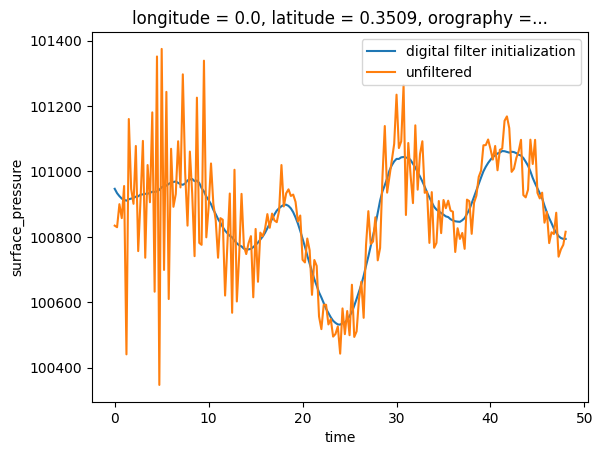

In [12]:
ds_out.surface_pressure.sel(latitude=0, longitude=0, method='nearest').plot.line(label='digital filter initialization');
ds_out_unfiltered.surface_pressure.sel(latitude=0, longitude=0, method='nearest').plot.line(label='unfiltered');
plt.legend()

### Visualize forecasts

This is a dycore only model, so physical variables are not necessarily not guaranteed to stay "reasonable."

For example, specific humidity increases to a unrealistically large maximum value at the middle sigma level:

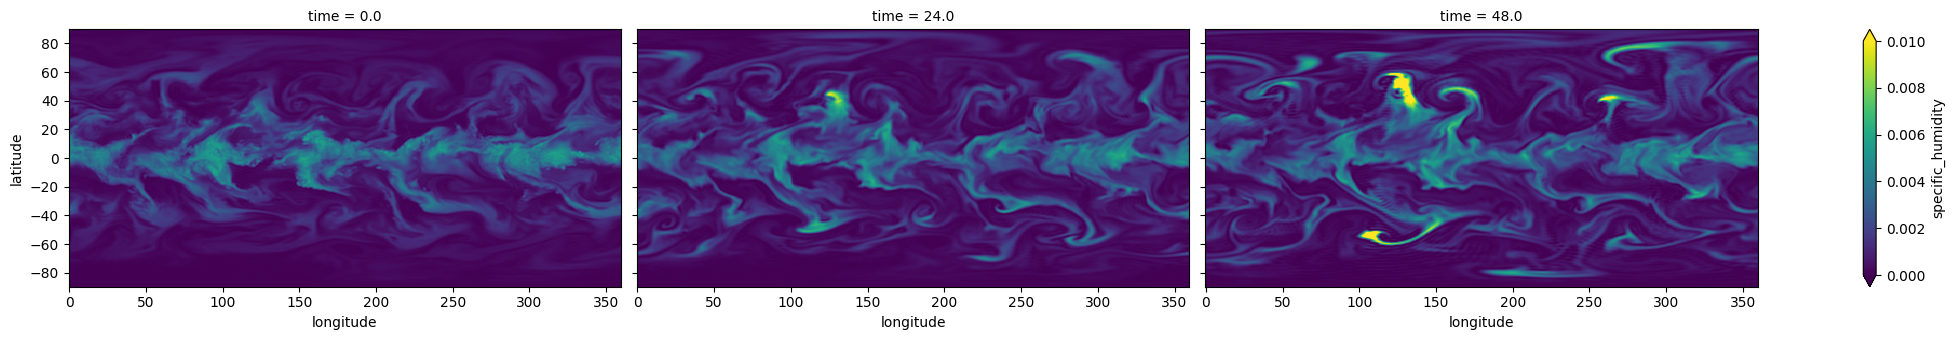

In [13]:
ds_out.specific_humidity.thin(time=4*24).isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=3, aspect=2, size=3.5,
    cmap='viridis', vmin=0, vmax=0.01,
)

As another example, cloud liquid water content has a very non-smooth initial condition, so it takes on some slightly negative values after evolution by the dycore. This could be fixed with additional filtering of initial conditions or by implementing an alternative advection scheme in Dinosaur (some form of limiter to ensure monotonic behavior):

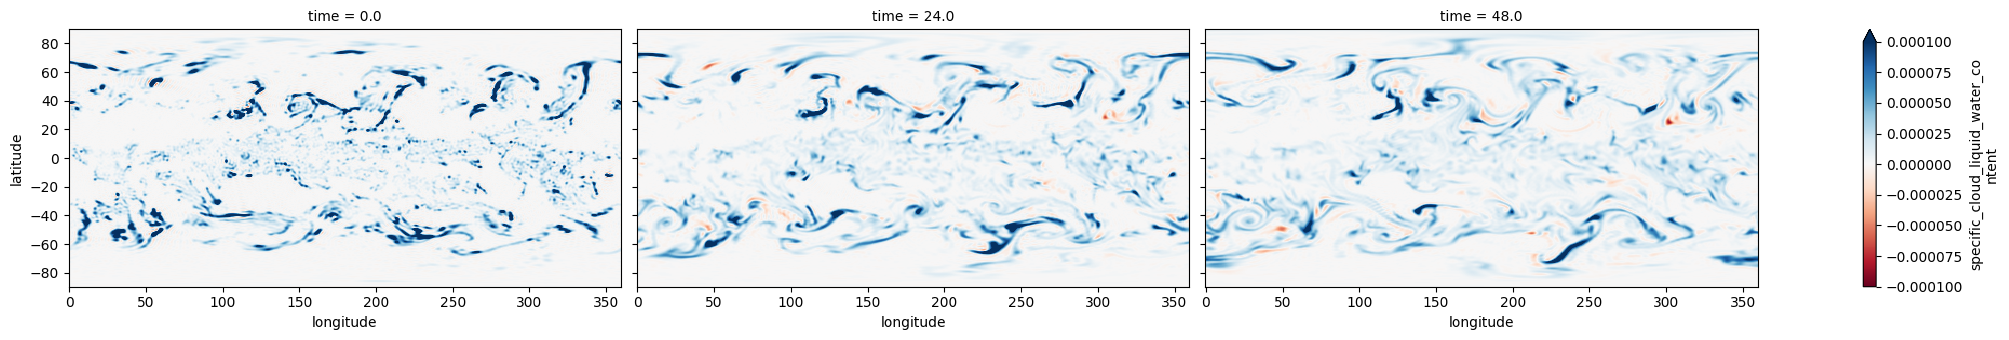

In [14]:
ds_out.specific_cloud_liquid_water_content.thin(time=4*24).isel(sigma=2).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=3, aspect=2, size=3.5,
    cmap='RdBu', vmin=-1e-4, vmax=1e-4,
)